In [1]:
import numpy as np
# import h5py 
# import tables
from scipy.io import loadmat

In [4]:
# import sys
# #sys.path.append("..")
# sys.path.append("/Users/jan/Documents/")

In [2]:
data_dir = "/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFi_Toolbox-master/ToFFi_Toolbox-20211013/DATA_PREPARATION/HCP_DATA_PREP/output/000000_RENAMED"

atlas_dir = '/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFi_Toolbox-master/ToFFi_Toolbox-20211013/commonData/Schaefer2018_100Parcels_7Networks_ATLAS_interpolated_on_8mm_HCP_template.mat'

template_dir = '/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFi_Toolbox-master/ToFFi_Toolbox-20211013/commonData/templategrid_HCP_8mm.mat'

In [3]:
# %cd '/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFi_Toolbox-master/ToFFi_Toolbox-20211013/DATA_PREPARATION/HCP_DATA_PREP/output/000000_RENAMED/Sub_1'

/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFi_Toolbox-master/ToFFi_Toolbox-20211013/DATA_PREPARATION/HCP_DATA_PREP/output/000000_RENAMED/Sub_1


In [3]:
!pwd

/Users/jan/Documents/Studia/AdvancedProgramming/project/PyToFFi


In [3]:
class DataWrap:
    '''Class for loading data in matlab format
    
    - Obligatory data structures with fields:
        - Data: self.sig['data']
            - trial 
            - time
            - label
            - fsample
        - spatial filter: self.lcmv['spatialFilter']
        - brain atlas
            - sourceAtlas:
                - dim: [20 25 22]
                - transform: [4×4 double] 
                - unit: 'cm'
                - tissue: [20×25×22 double]
                - tissuelabel: {1×100 cell}
        - common source grid = sourcemodel = template grid = commonData/templategrid_HCP_8mm.mat
            - xgrid
            - ygrid
            - zgrid
            - dim
            - pos
            - inside
            - outside
    
    '''
    
    
    def __init__(self, data_dir: str, sub: int, sourcemodel: str):
        self.data_dir = data_dir #loading the data directory path
        self.cov = loadmat(f'{data_dir}/Sub_{sub}/data_clean_covmat_HCP_att2_{sub}.mat', simplify_cells=True) #loading covariance matrix
        self.sig = loadmat(f'{data_dir}/Sub_{sub}/data_clean_HCP_att2_{sub}.mat', simplify_cells=True) #loading data frame - MGE signal etc.
        self.lcmv = loadmat(f'{data_dir}/Sub_{sub}/flt_LCMV_HCP_att2_{sub}.mat', simplify_cells=True) #loading lcmv filter
        self.template = loadmat(f'{template_dir}', simplify_cells=True)
        
        self.data = self.sig['data']
        
        # self.fsample = self.sig['data']['fsample']
        # self.trial = self.sig['data']['trial']
        # self.time = self.sig['data']['time']
        # self.label = self.sig['data']['label']
        
        self.atl = loadmat(atlas_dir, simplify_cells=True)
        self.atlas = self.atl['sourceAtlas']
        # self.dim = self.atlas['dim']#[0][0][0][0]
        # self.transform = self.
        
        self.sourcemodel = self.template['sourcemodel']


In [4]:
sub_3 = DataWrap(data_dir=data_dir, sub=3, sourcemodel=template_dir)

In [5]:
sub_3.lcmv['spatialFilter'].shape

(5798, 245)

1. co to są cell array w matlabie - wielowymiarowa lista
2. array w matlab - przechowuje tylko jeden typ
3. supfunsim - paper - klasy itd

4. rm_output_data - usuwanie outputi
5. skrypt integrate

6. STAGE 1 source projection 

7. Beamforming - lcmv

8. Use group atlas from commonData 

sub_1.data['hdr']['Fs'] #original sampling rate = 2034...

sub_1.sig['data']['fsample'] # GO TO reduced sampling rate for computations = 508...

9. Mnożenie '*' w Matlabie to matrix multip. '.*' 

sub_3.data['trial'][0].shape #badani mogą mieć różną liczbę kanałów, 509 próbek sygnału powinno być dla każdego

(245, 509)

CFG.(STAGE_NAME).frequenciesOfInterest = logspace(0, log10(40), 20);

NormalizeActivity - over whole brain (ToFFi) - po wszystkich voxelach i wszystkich trialach - używane do przeskalowania każdego okna czasu osobno

from matlab doc, how to get onesided spectrum:

    P2 = abs(Y/L); -> two sided
    P1 = P2(1:L/2+1); -> one sided
    -> so in python: P1 = P2(0:L/2)

# SourceProjection

In [6]:
def sourceProjection(data, lcmv):
    
# """  
#   Calculates product of data matrix and spatial filter matrix in order to
# perform source activity reconstruction.

# More on the topic:
# [1] K. Sekihara and S. S. Nagarajan, Adaptive Spatial Filters for
#     Electromagnetic Brain Imaging. Berlin Heidelberg: Springer-Verlag, 2008.
# % Inputs
# *cfg* - [] (empty) in current version.

# *data* - structure containing following fields:

# _trial_ - cell containing 2D-arrays (sensors x time frames) signal values for
# single epochs of the multichannel signal (time segments).

# _time_ - cell containing 1D-arrays (1 x time frames) containing time
# values for single epochs of the multichannel signal (time segments).

# _label_ - cell containing names of the sensors (e.g. EEG electodes, MEG squids).

# _fsample_ - double; sampling frequency in Hz

# *spatialFilter* - double; 2D-array which represents spatial filter
#                   coefficients used for reconstruction on brain activity
#                   from sensors signal (see e.g. Van Veen 1997 to learn
#                   about LCMV spatial filter).
# % Outputs
# *sourceTimeSeries* - structure containing following fields:

# _trial_ - cell containing 2D-arrays (sources x time frames) reconstructed
# source activity signal values for single epochs (time segments).

# _time_ - cell containing 1D-arrays (1 x time frames) containing time
# values for single epochs of the reconstructed activity signal.

# _fsample_ - double; sampling frequency in Hz

# _label_ - cell containing working names of the sources
#           ({'src_1', 'src_2', ..., 'src_5998}).
#   """


    print('Source projection ...')
    sourceTimeSeries = {}
# SOURCE PROJECTION: apply weights to a sensor signal
    numTrials                    = len(data['trial'])
    numSources                   = lcmv['spatialFilter'].shape[0]
    sourceTimeSeries['trial']    = np.empty(shape=(1, numTrials), dtype=object)
    sourceTimeSeries['time']     = data['time']
    sourceTimeSeries['fsample']  = data['fsample']
    sourceTimeSeries['label']    = np.empty((numSources, 1),dtype=object) # labels are needed to perform ft_freqanalysis

    for src in range(0,numSources):
        sourceTimeSeries['label'][src] = sourceTimeSeries['label'][src]
        sourceTimeSeries['label'][src] = 'src_'+str(src)
    

    # # source projection: q = Wy
    for tt in range(0,numTrials): #CHANGED FROM 1-indexing IN MATLAB
        sourceTimeSeries['trial'][0][tt] = np.matmul(lcmv['spatialFilter'],data['trial'][tt])
    

    if 'sampleinfo' in data.keys():
        sourceTimeSeries['sampleinfo'] = data['sampleinfo']
    

    return sourceTimeSeries


In [7]:
data_src = sourceProjection(sub_3.data, sub_3.lcmv)

Source projection ...


# Frequency analysis

In [8]:
import math
# from scipy.signal import windows
# from scipy.fft import fft
import matplotlib.pyplot as plt

In [9]:
# data_src['trial'][0].shape
data_src['time'].shape

(282,)

In [10]:
print('Calculating power spectra for each time segment ...')

cfg = {}
cfg['frequencies'] = np.logspace(0,math.log(40, 10),num=20)

Calculating power spectra for each time segment ...


In [11]:
print(data_src['trial'].shape,"\n",
      data_src['trial'][0].shape, "\n",
      data_src['trial'][0][0].shape)

(1, 282) 
 (282,) 
 (5798, 509)


In [ ]:
#Robert C. Martin

In [12]:
from spectrum import *
# res = pmtm(signal, NW=2.5, k=5, show=False, method='unity')

In [144]:
trials = data_src['trial'][0]
n_trials = data_src['trial'][0].shape[0]
n_src = data_src['trial'][0][0].shape[0]
print(n_src, n_trials)

5798 282


In [145]:
n_src

5798

In [146]:
pow_spectra = np.empty((282, 5798), dtype=object)
trial_idx = 0
for i_trial in trials:
    
    for i_src in range(0,n_src):
        spectrum_windowed = pmtm(i_trial[i_src,:], NW=2.5, k=5, show=False, method='unity')[0]
        pow_spectrum_trial = abs(spectrum_windowed)**2
        pow_spectrum_trial = np.mean(pow_spectrum_trial,axis=0)
        pow_spectra[trial_idx, i_src] = pow_spectrum_trial[0:int(len(pow_spectrum_trial)/2)]
        #na wyjściu - zbiór power spectrum dla każdego źródła dla każdego sampla
        #uśrednianie 
        
    trial_idx += 1

In [147]:
np.save('/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFiPy/pow_spectra', pow_spectra)

## Normalizing power spectra across whole brain

In [150]:
pow_spectra[0,0].shape

(256,)

In [151]:
mean_pow_spectra_trials = np.mean(pow_spectra, axis=0)

In [154]:
mean_pow_spectra_trials_and_vox = np.mean(mean_pow_spectra_trials)

In [ ]:
mean_pow_spectra_trials_and_vox

In [ ]:
# pow_spectra = np.load('/Users/jan/Documents/Studia/AdvancedProgramming/project/ToFFiPy/pow_spectra.npy', allow_pickle=True)

In [162]:
pow_spectra_normalized = np.empty((282, 5798), dtype=object)

trial_idx = 0
for i_trial in trials:
    
    for i_src in range(0,n_src):
        pow_spectra_normalized[trial_idx, i_src] = pow_spectra[trial_idx, i_src]/mean_pow_spectra_trials_and_vox
        
    trial_idx += 1

In [170]:
pow_spectra_normalized.shape

(282, 5798)

## Trying scipy dpss multitapering

In [ ]:
cfgFreq = {}


cfgFreq['method'] = 'mtmfft'
cfgFreq['output'] = 'pow'
cfgFreq['taper']  = 'dpss'
cfgFreq['tapsmofrq'] = 2
cfgFreq['pad'] = 2
cfgFreq['keeptrials'] = 'yes'
cfgFreq['foi'] = cfg['frequencies']

# powSpectra  = ft_freqanalysis(cfgFreq, timeSeries);
# outputFrequencies   = powSpectra.freq;


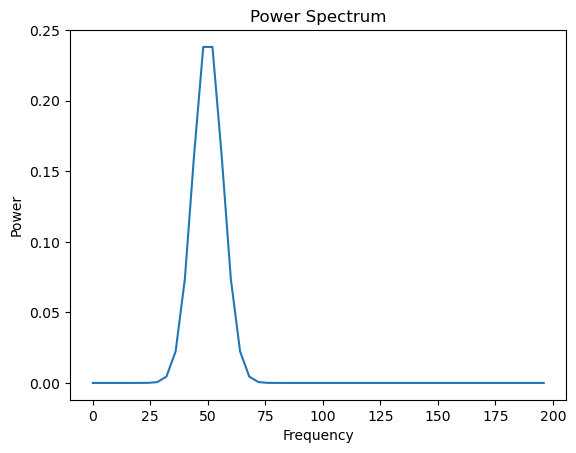

In [17]:
import numpy as np
import scipy.signal.windows as windows

# Generate a signal
N = 1024  # Number of samples
t = np.arange(N)  # Time vector
signal = np.sin(2 * np.pi * 50 * t / N)# + np.sin(2 * np.pi * 25 * t / N)  # Example signal (10 Hz sine wave)

# Compute the DPSS window
M = 256  # Length of the window
NW = 8  # Normalized half-bandwidth (odpowiednik spectral smoothing) BW/df

window = windows.dpss(M, NW)

# Apply the window to the signal
windowed_signal = signal[:M] * window

# Compute the power spectrum
spectrum = np.abs(np.fft.fft(windowed_signal))**2

# Normalize the spectrum
spectrum /= np.sum(window)**2

# Frequency vector
freq = np.fft.fftfreq(M, d=1/1024)

# Plot the power spectrum
import matplotlib.pyplot as plt
plt.plot(freq[:50], spectrum[:50])
# plt.plot(t, signal)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.show()